In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.font_manager
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'NEXON' in f.name]
# print ('캐시 위치: ', matplotlib.get_cachedir())

plt.style.use('seaborn-dark')
plt.rcParams["font.family"] = 'NEXON Lv2 Gothic'
plt.rcParams["font.weight"] = 'light'

plt.rcParams['axes.unicode_minus'] = False

In [2]:
station = pd.read_csv(
    "assets/newStationInfo.csv", index_col=0,encoding='cp949'
)

near_bus = pd.read_csv(
    "assets/near_bus_500m.csv", encoding="CP949", index_col=0
)

seoul_bike = pd.read_parquet("/Users/yangwoolee/git_repo/seoulBikeProject/parquet/220607_bike_record.parquet.gzip")

sub_info = pd.read_csv(
    "assets/sub_and_bike_info.csv", encoding="CP949", index_col=0
)

search_info = pd.read_csv(
    "assets/search_info.csv", encoding="CP949", index_col=0
)
btstation = pd.read_csv(
    "assets/btbtstation_info.csv", encoding="CP949", index_col=0
)

near_sub = pd.read_csv(
    "assets/near_sub_station.csv", encoding="CP949", index_col=0
)

In [187]:
def haversine_np(
    lon1: float, lat1: float, lon2: float, lat2: float
) -> np.array:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

def raw_data( val: int) -> pd.DataFrame:
    quert_st_id1 = seoul_bike[seoul_bike["st_id1"] == val]
    quert_st_id2 = seoul_bike[seoul_bike["st_id2"] == val]
    filtered_data = pd.concat(
        [quert_st_id1, quert_st_id2], axis=0
    ).drop_duplicates()
    filtered_data.drop(columns="index", inplace=True)
    bm = (filtered_data["st_id1"] == val) & (filtered_data["st_id2"] == val)
    filtered_data = filtered_data[~bm]

    # # 반납
    # filtered_data_end = filtered_data[
    #     (filtered_data["st_id2"] == val) & (filtered_data["st_id1"] != val)
    # ]

    return filtered_data

# def findInteractionNum(id:int) :
def stationInteraction(id:int) :
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    data = stationInteraction[stationInteraction>=int(len(stationInteraction)/1000)].sort_values(ascending=False)
    result = pd.DataFrame(data).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2',0]]
    return result

def drawMap(startId,ids:list) : 
    if type(ids) == str :
        ids = [ids]

    stationInfo = station[station['st_id'].isin(ids)]
    fig = px.scatter_mapbox(
    stationInfo,
    lat="latitude",
    lon="longtitude",
    hover_data={'latitude':False,'longtitude':False,'st_name':True},
    opacity=0.8,
    # marker=14,
    custom_data=["st_name"],
)
    stationInfo = station[station['st_id'].isin([startId])]
    fig2 = px.scatter_mapbox(
    stationInfo,
    lat="latitude",
    lon="longtitude",
    hover_data={'latitude':False,'longtitude':False,'st_name':True},
    opacity=0.8,
    # marker=14,
    custom_data=["st_name"],
    color=["출발"],
    color_discrete_sequence=["#35C768"]
)
    fig.add_trace(fig2.data[0])

    fig.update_traces(marker={'size': 15})

    fig.update_layout(
                margin=dict(l=0, r=0, t=0, b=0),
                mapbox_zoom=12,
                mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
                mapbox=dict(
                    accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
                    style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
                ),
                legend=dict(
                    yanchor="top",
                    y=0.82,
                    xanchor="right",
                    x=0.95,
                    bgcolor="rgba(223, 235, 223, 0.8)",
                    # title={"text": None},
                ))
    return fig

In [ ]:
### Filtering Station

In [383]:
# 1000m 내에 있는 대여소 제거
def filterIn1000M(id:int) -> pd.DataFrame :
    k = station[station['st_id'] == id]
    tLong = k['longtitude'].values
    tLat = k['latitude'].values
    bLong=station['longtitude']
    bLat=station['latitude']
    dist = haversine_np(tLong,tLat,bLong,bLat)

    subInfoCopy = station.copy()
    subInfoCopy['dist'] = dist
    bikeSort = subInfoCopy[(dist < 1000)]

    return bikeSort

# 대여기록 비율 1/2 차이나는 경우 station으로 미포함
def calculateBikeRate(id1:int, id2:int, rawData)-> pd.Series :
    k = rawData[(rawData['st_id1'] == id1) & (rawData['st_id2'] == id2)] # 주 목적
    kk = rawData[(rawData['st_id1'] == id2) & (rawData['st_id2'] == id1)] # 비교 목적
    if len(k) and len(kk) :
        rere = np.log2(len(k)/len(kk))
        if rere > -1 :
            return k    

# 조건 1,2 정제해서 index로 반환
def filterConditions(id1:int,rawData) -> np.array :
    # rawData = raw_data(id1)
    id2List = filterIn1000M(id1)['st_id'].to_numpy()

    # 조건 1 : 대여기록 0.001 이상
    id1Value = rawData['st_id2'].value_counts()[1:]
    id1List= id1Value[id1Value>int(len(rawData)*0.001)].index.to_numpy() 

    #조건 2 : 비율 2배 이상, 고도 차이 20m 이상 제거
    filteredidx = id1List[~(np.in1d(id1List,id2List))] 
    result = [calculateBikeRate(id1,id2,rawData) for id2 in filteredidx]

    returnValue : np.array = pd.concat(result)['st_id2'].value_counts().index.to_numpy()
    return returnValue

#예시
# len(filterConditions(758,rawData=raw_data(758)))
# filterIn1000M(758)
# arrStation(758)


In [431]:
# 예상거리, 시간, 출발 대여소까지 직선 거리 계산
def filterRawStations(st_id: int) -> pd.DataFrame:
    filtered_data = raw_data(st_id)

    # 대여소 idx 추출
    station_id = filterConditions(st_id,filtered_data).tolist()
    result = station[station['st_id'].isin(station_id)].reset_index(drop=True)

    result_station = []
    for j in result['st_id']:
        # 예상시간 계산
        BM = filtered_data["st_id2"] == j

        all_rent = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )

        ### 대여기록
        total_record = all_rent.sum()

        k = []
        i = 2
        ### 기록 많은 순만 종합
        while len(k) < 1:
            k = all_rent[all_rent >= (total_record / i)]
            i = i * 1.5

        ### 대여시간
        ind = k.index

        ### 대여기록
        val = k.values

        ### 대여기록 합
        a = k.sum()

        ### 대여시간 * 대여기록
        asddd = sum([a * b for a, b in zip(ind, val)])

        # 평균 시간
        ddddd = asddd / a

        # 올림
        val = round(ddddd, 0)

        ### 이동거리 계산
        BM = filtered_data["st_id2"] == j
        all_rent = (
            filtered_data[BM]["dist"].value_counts().sort_values(ascending=False)
        )

        dist = (
            pd.cut(all_rent.index, bins=50)
            .value_counts()
            .sort_values(ascending=False)
        )
        # 상위 3개 값을 평균냄. mid는 pd.interval 매서드에서 쓰는 변수임.
        num = 3
        vals = [dist[:num].index[a].mid * dist.iloc[a] for a in range(num)]
        avg_dist = sum(vals) / sum(dist.to_list()[:num])
        result_station.append([val, total_record, (round(avg_dist / 1000, 2))])
    
    # 결과 종합
    df = pd.DataFrame(result_station)

    # haversineDist 계산
    dep = station[station['st_id'].isin([st_id])]
    arr = result

    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']

    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(round(dist/1000,2),columns=['haversineDist'])

    # 데이터 종합
    data = pd.concat([result, df,dist], axis=1)
    data.columns = ['st_id','st_name','district','latitude', 'longtitude','num',  'elevation','ridingTime','record','ridingDist','haversineDist']
    data=data[data['st_id'] != st_id]

    return data

### 예시
filterRawStations(207)

,st_id,st_name,district,latitude,longtitude,num,elevation,ridingTime,record,ridingDist,haversineDist
0,106,합정역 7번출구 앞,마포구,37.548645,126.912827,63341.0,16.01,38.0,714,5.70,2.95
1,111,상수역 2번출구 앞,마포구,37.547871,126.923531,27009.0,22.17,37.0,199,4.76,2.44
2,114,홍대입구역 8번출구 앞,마포구,37.557060,126.924423,59233.0,12.07,46.0,191,6.63,3.41
3,119,서강나루 공원,마포구,37.545284,126.931053,27721.0,13.02,16.0,238,3.40,2.04
4,130,신촌역(2호선) 7번출구 앞,마포구,37.554859,126.936157,35571.0,19.44,38.0,194,5.09,3.12
...,...,...,...,...,...,...,...,...,...,...,...
77,3794,안양천합수부(현대3차아파트),강서구,37.552246,126.876488,27755.0,7.15,34.0,405,6.83,5.65
78,4559,신길역 2번출구,영등포구,37.517563,126.916985,17128.0,18.68,15.0,300,1.98,1.69
79,4568,영등포로터리,영등포구,37.518749,126.912209,13119.0,11.10,18.0,218,2.58,1.98
80,152,마포구민체육센터 앞,마포구,37.556610,126.898018,104386.0,9.01,44.0,261,7.22,4.46


In [ ]:
def extractStations(id:str) -> pd.DataFrame :
    
    # 필터링 된 Station 불러오기 
    filteredStation = filterRawStations(id)

    # 최대 거리
    maxDist = int(filteredStation['haversineDist'].max())

    resultfinish = []
    for i in range(0,maxDist+1) : 

        #거리별로 나누기
        dist = filteredStation[(filteredStation['haversineDist']> i) & (filteredStation['haversineDist'] < i+1)]
        val = filteredStation.copy()[filteredStation['st_id'].isin(dist['st_id'].tolist())]

        # 거리별 index 추가
        val['distLabel'] = i

        if len(val) > 5 :
            # 좌표 추출
            coor = val[['latitude','longtitude']].values

            # kmeans 1차
            kmeans = KMeans(n_clusters=5,random_state=42)
            kmeans.fit_transform(coor)
            newK = val.copy()
            newK['label'] =kmeans.labels_
            newK=newK.sort_values(by='record',ascending=False)
            
            # Kmeans 2차
            result_under =[]
            for i in range(5) :
                test12 = newK[newK['label'] == i][['latitude','longtitude']]
                # print('len :',len(test12))
                # Cluster = 4
                # if len(test12) >= 5 : 
                #     test = KMeans(n_clusters=5)
                #     test.fit(test12)
                #     test12['label2'] = test.labels_

                # Cluster = 1 ~ 4
                if len(test12) >=1 :
                    test = KMeans(n_clusters=int(len(test12)/2)+1)
                    test.fit(test12)
                    test12['label2'] = test.labels_

                # Cluster = 0
                else :
                    test12['label2'] = 0

                # 상위 2개만 추출하기 
                result = []
                for i in range(int(len(test12)/2)+1) :
                    v = test12[test12['label2'] == i]
                    v = v.iloc[:1]
                    result.extend(v.index)   

                # Append Items
                newcoor = newK[newK.index.isin(result)]
                result_under.append(newcoor)
        
            resultfinish.extend(result_under)

        # 5개 미만은 그냥 넣기        
        else : 
            val['label'] = 4
            resultfinish.append(val)


    # 종합
    result=pd.concat(resultfinish).drop_duplicates(subset='st_id')

    return result

#-- 값 넣기 --#
id = 754
result = extractStations(id)
print(len(result))

#-- plot --#
fig = px.scatter_mapbox(result,lat='latitude',lon='longtitude',color='distLabel',hover_data=['record'],
color_continuous_scale='Aggrnyl')
fig2 = px.scatter_mapbox(station[station['st_id']==id],lat='latitude',lon='longtitude')

fig.add_trace(fig2.data[0])
fig.update_traces(marker={'size': 15})
fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),
            mapbox_zoom=12,
            # mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
            mapbox=dict(
                accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
                style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
            ),
            legend=dict(
                yanchor="top",
                y=0.82,
                xanchor="right",
                x=0.95,
                bgcolor="rgba(223, 235, 223, 0.8)",
                # title={"text": None},
            ))

fig.show()


In [ ]:
# ## Cluster 다른 방식으로 해봄 근데 더 안좋은듯

# #Cluster로 먼저 군을 모은 다음
# #그 안에서 거리별로 다시 클러스터링을 하는 방식임. 근데 별로임 

# def test123(id) :
#     filteredStation = filterRawStations(id)
#     km = KMeans(n_clusters=5,random_state=42)
#     km = km.fit(filteredStation[['longtitude','latitude']])
#     filteredStation['label']=km.labels_


#     resultfinish =[]
#     for i in range(5) :
#         newK = filteredStation[filteredStation['label'] == i]

#         if len(newK) > 5 :
#             maxDist = int(newK['haversineDist'].max())
#             minDist = int(newK['haversineDist'].min())

#             result_under =[]
#             for i in range(minDist,maxDist+1,2) :
#                 #거리별로 나누기
#                 dist = newK[(newK['haversineDist'] >= i) & (newK['haversineDist'] < i+1)].copy()
#                 # 거리별 index 추가
#                 dist['distLabel'] = i
#                 coor= dist[['longtitude','latitude']].copy()

#                 # # Cluster = 1 ~ 4
#                 # if len(coor) > 5 :
#                 #     test = KMeans(n_clusters=5)
#                 #     test.fit(coor)
#                 #     coor['label2'] = test.labels_

#                 # Cluster = 1 ~ 4
#                 if len(coor) > 1 :
#                     test = KMeans(n_clusters=int(len(coor)/2)+1)
#                     test.fit(coor)
#                     coor['label2'] = test.labels_

#                 # Cluster = 0
#                 else : 
#                     coor['label2'] = 0

#                 # 상위 2개만 추출하기 
#                 result = []
#                 for i in range(int(len(coor)/2)+1) :
#                     v = coor[coor['label2'] == i]
#                     v = v.iloc[:1]
#                     result.extend(v.index)   

#                 # Append Items
#                 newcoor = dist[dist.index.isin(result)]
#                 result_under.append(newcoor)

#         else : 
#             result_under.append(newK)


#         resultfinish.extend(result_under)

#     result=pd.concat(resultfinish).drop_duplicates(subset='st_id')

#     return result

# id = 755
# result = test123(id)
# print(len(result))

# filteredStation = filterRawStations(id)
# km = KMeans(n_clusters=5,random_state=42)
# km = km.fit(filteredStation[['longtitude','latitude']])
# filteredStation['label']=km.labels_

# result = filteredStation


# fig = px.scatter_mapbox(result,lat='latitude',lon='longtitude',color='label',hover_data=['record'],
# color_continuous_scale='Aggrnyl')
# fig2 = px.scatter_mapbox(station[station['st_id']==id],lat='latitude',lon='longtitude')

# fig.add_trace(fig2.data[0])
# fig.update_traces(marker={'size': 15})
# fig.update_layout(
#             margin=dict(l=0, r=0, t=0, b=0),
#             mapbox_zoom=11,
#             # mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
#             mapbox=dict(
#                 accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
#                 style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
#             ),
#             legend=dict(
#                 yanchor="top",
#                 y=0.82,
#                 xanchor="right",
#                 x=0.95,
#                 bgcolor="rgba(223, 235, 223, 0.8)",
#                 # title={"text": None},
#             ))

# fig.show()




### Log로 그려보기


In [ ]:
copydist = dist.copy()
copydist['log'] =  np.log(dist['count'])
copydist.plot.scatter('dist','log',figsize=(7,5))
plt.xlabel(xlabel='대여소 간 거리(Km)')
plt.ylabel(ylabel='대여건수(Log)')
### 전체 대여소의 대여소 거리 및 count 종합

In [ ]:
# totalList = list(map(lambda x : haversineOneStation(x,station),station['st_id']))
# totalDataFrame = pd.concat(totalList)
# totalDataFrame.head(3)

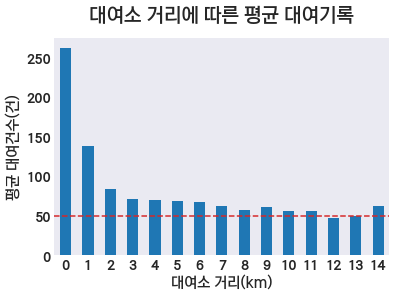

In [59]:
# # 30건 이상 대여기록만 포함
# k =totalDataFrame[['dist','count']].query('dist > 0 & count >30').reset_index(drop=True)

# # 15개 범위로 자르기
# bins = list(range(0,15))
# bins.append(int(k['dist'].max()))
# k['cat'] = pd.cut(k['dist'], bins=bins)

# # 대여소 간 직선거리에 따른 평균 대여기록
# x = k.groupby(by='cat')['count'].mean()
# kkk = pd.DataFrame(x).reset_index(drop=False)
# kkk.plot.bar(rot=0)

# # x,y labels and ticks

# plt.title(label='대여소 거리에 따른 평균 대여기록',fontdict={'size': 20},y=1.05)
# plt.xlabel(xlabel='대여소 거리(km)',fontdict={'size':15})
# plt.ylabel(ylabel='평균 대여건수(건)',fontdict={'size':15})
# plt.xticks(fontsize=13,weight='bold')
# plt.yticks(fontsize=13,weight='bold')

# # red dot line
# avg = int(np.mean(totalDataFrame.query('dist >= 2')['count']))
# plt.axhline(y=50, color='tab:red',linestyle='--')

# # off some fetures
# plt.legend().remove()
# plt.grid(False)

In [62]:
# bins = list(range(0,15))
# bins.append(int(k['dist'].max()/1000))
# kkkk = pd.cut(k['dist']/1000, bins, right=False)
# kkkk.values.describe()


### A->B, B->A 대여소 이동 비율 계산

In [26]:
## Save File로 대체

wholeCount= list(map(stationInteraction,station['st_id'].tolist()))
c = pd.concat(wholeCount)

# st_id == st_id2 and st_id2 == st_id1
def findId1AndId2(id1,id2,c) : 
    
    test1 = np.in1d(c['st_id1'],np.array([id1])) 
    test2 = np.in1d(c['st_id2'],np.array([id2]))
    val1 = c[test1 & test2][0].values[0]
    
    # id2 to id1은 없을 수 있으니 try Execpt 활용 
    try : 
        test3 = np.in1d(c['st_id1'],np.array([id2])) 
        test4 = np.in1d(c['st_id2'],np.array([id1]))
        val2 = c[test3 & test4][0].values[0]
    except :
        # 최소 대여기준이 10건이므로 그 절반인 5를 기본 값으로 넣음
        val2 = 5

    result = [id1,id2,val1,val2]
    return result

findId1AndId2(103,101,c)
# return id1, id2, 1->2 ,2->1


[103, 101, 39, 37]

In [28]:

# jDown = 2to1 / 1to2
# jUp = 1to2 / 2to1

#jDown
# st_id1, st_id2 추출
newC = c[~(c['st_id1'] == c['st_id2'])]
st_id1 = newC[newC['st_id1'] < newC['st_id2']]['st_id1'].tolist()
st_id2 = newC[newC['st_id1'] < newC['st_id2']]['st_id2'].tolist()

# 전체 대여소에 적용
k = [findId1AndId2(a,b,c) for a, b in zip(st_id1,st_id2)]


# 결과 dataframe으로
jDown = pd.DataFrame(k)
jDown.columns = ['st_id1','st_id2','1to2','2to1']

# 에러 제거
BM=(jDown['st_id1'].isin([3,5]) | jDown['st_id2'].isin([3,5]))
jDown = jDown[~BM]

# 비율 계산
jDown['2to1']=jDown['2to1'].replace(5,10)
jDown['logRate']= np.log2(jDown['1to2']/jDown['2to1'])




#jUp
# st_id1, st_id2 추출
newC = c[~(c['st_id1'] == c['st_id2'])]
st_id1 = newC[newC['st_id1'] > newC['st_id2']]['st_id1'].tolist()
st_id2 = newC[newC['st_id1'] > newC['st_id2']]['st_id2'].tolist()

# 전체 대여소에 적용
k = [findId1AndId2(a,b,c) for a, b in zip(st_id1,st_id2)]

# 결과 dataframe으로
jUp = pd.DataFrame(k)
jUp.columns = ['st_id1','st_id2','1to2','2to1']

# 에러 제거
BM=(jUp['st_id1'].isin([3,5]) | jUp['st_id2'].isin([3,5]))
jUp = jUp[~BM]


# 비율 계산
jUp['2to1']=jUp['2to1'].replace(5,10)
jUp['logRate']= np.log2(jUp['1to2']/jUp['2to1'])


# 2to1 / 1to2 ==> 1to2 / 2to1
jDown = jDown[['st_id2','st_id1','2to1','1to2','logRate']]
jDown.columns = 'st_id1','st_id2','1to2','2to1','logRate'

newJ = pd.concat([jUp,jDown],axis=0).drop(columns='logRate')
newJ=newJ.drop_duplicates(subset=['st_id1','st_id2'])
newJ['logRate'] = np.log2(newJ['1to2']/newJ['2to1'])

# 고도정보 합치기
j = newJ
ele = station[['st_id','elevation']]
newJ = pd.merge(left=j,right=ele, left_on='st_id1',right_on='st_id')
newJ = pd.merge(left=newJ,right=ele, left_on='st_id2',right_on='st_id')
newJ = newJ.drop(columns=['st_id_x','st_id_y'])

# 종합
newJ.columns = 'st_id1','st_id2','1to2','2to1','logRate','elevation1','elevation2'
newJ.to_csv('./assets/saveForBikeRate.csv',encoding='cp949')


In [609]:
j = pd.read_csv('./assets/saveForBikeRate.csv',encoding='cp949',index_col=0).sort_values(by='logRate',ascending=False)

j.head(3)
### logRate 
# 1to2 2to1
# 1:1 = 0
# 2:1 = 1
# 4:1 = 2
# 1:2 = -1
# 1:4 = -2

,st_id1,st_id2,1to2,2to1,logRate,elevation1,elevation2
135752,2092,2026,505,12,5.395177,60.07,15.18
116874,1550,1531,291,10,4.862947,72.33,30.85
140277,3310,2169,1666,66,4.657779,72.85,28.14


In [ ]:
# result = []
# for i in np.arange(0,4,0.2) :
#     topk = j[j['logRate'] >=i].reset_index()
#     topk = topk.eval('diff = elevation1 - elevation2')
#     # print(round(np.mean(topk['diff']),2))

#     topk1 = topk[topk['diff'] > 20]
#     result.append(round(len(topk1)/len(topk),2))

# plt.figure(figsize=(5,5))
# plt.bar(np.arange(0,4,0.2),result,color='tab:green',linewidth=1,edgecolor='black')

In [ ]:
# j = j.eval('diff = elevation1 - elevation2').query('4.6 > logRate >= 0').query('diff > 0')
# b = j[['logRate','diff']]
# k = np.arange(0,5,0.2)
# kInf = np.append(k,np.inf)
# b['cat'] = pd.cut(b['logRate'],bins=kInf, labels=k, right=False)
# newb = b.groupby(by='cat')['diff'].mean().reset_index()

In [610]:
j['1to2Rate'] = j['1to2']/j['2to1']
j=j.eval('diff = elevation1 - elevation2')

In [562]:
# newj = j[['diff','1to2Rate']]

<AxesSubplot:xlabel='diff', ylabel='1to2Rate'>

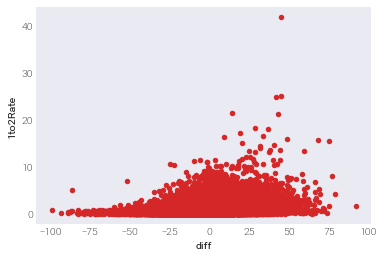

In [611]:
j[j['2to1']>10].plot.scatter(x='diff',y='1to2Rate',c='tab:red')


In [616]:
up = j['1to2Rate'].quantile(0.975)
down = j['1to2Rate'].quantile(0.025)
quantileJ = j[(j['1to2Rate'] < up) &(j['1to2Rate'] > down)]


In [615]:
# quantileJ['diff'].max()

101.05

In [711]:
quanJ

cat
0     1.127785
10    1.220461
20    1.318326
30    1.387942
40    1.496168
50    1.503028
60    1.620544
70    1.607643
80    1.626471
90    1.809957
Name: 1to2Rate, dtype: float64

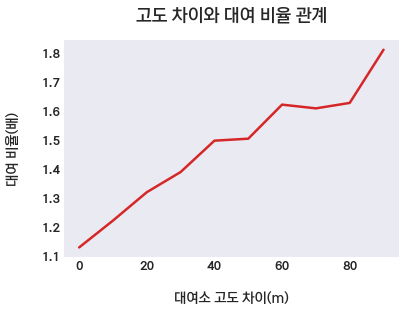

In [748]:
sns.lineplot(data=quanJ,color='tab:red',linewidth=2.5)
plt.xlabel('대여소 고도 차이(m)',fontdict={'fontsize':14},labelpad=20)
plt.ylabel('대여 비율(배)',fontdict={'fontsize':14},labelpad=20)
plt.title('고도 차이와 대여 비율 관계',fontdict={'fontsize':18},pad=20)
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')
plt.show()


/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_19204/231735527.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(-5.0, 105.0)

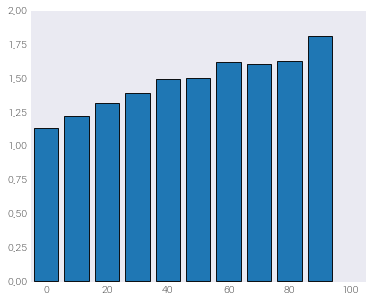

In [709]:
label = list(range(-100,100,10))

quantileJ['cat']= pd.cut(quantileJ['diff'], bins=np.linspace(-100,100,21),labels=label)
quanJ = quantileJ.groupby(by='cat')['1to2Rate'].mean()
quanJ = quanJ[quanJ.index>=0]
plt.figure(figsize=(6,5))
plt.bar(quanJ.index, quanJ,width=8,edgecolor='black',linewidth=0.9)
plt.Line2D(xdata=quanJ.index, ydata=quanJ)
plt.ylim(-0.01,2)
plt.xlim(-5,105)


In [590]:
#1to2 체크중
a = topk[['st_id1','st_id2']].values.tolist()
find = [1671,449]
# find = a[0]
kb = btstation[(btstation['value'].isin(find))].sort_values(by='value',ascending=False)
print(f'출발 대여소 : {kb.label.values[0]} ||  id : {kb.value.values[0]}')
print(f'도착 대여소 : {kb.label.values[1]} ||  id : {kb.value.values[1]}')
print('')
id1 = kb.value.values[0]
id2 = kb.value.values[1]
print(f'전체 대여기록 {len(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)])} 건')
print(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)]['date'].dt.hour.value_counts().head(5))

# drawMap(find)

출발 대여소 : 인덕대학교 ||  id : 1671
도착 대여소 : 일성아파트 ||  id : 449

전체 대여기록 112 건
5    112
Name: date, dtype: int64


In [124]:
test1 = np.abs(k['logRate'])
# test2= pd.cut(test1,bins=[0,1,2,3,4,8],labels=['1~2배','2~4배','4~8배','8~16배','16배~'])
test2= pd.cut(test1,10)
# test2 = test2.fillna(0)

<AxesSubplot:xlabel='categories'>

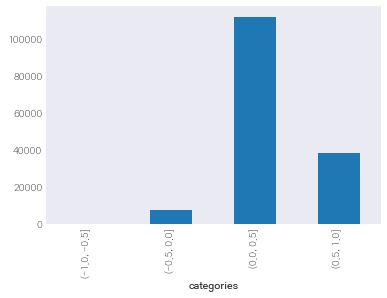

In [125]:
test2= pd.cut(test1,bins=[-6,-2,-1,1,2,6])
test2bar = test2.values.describe()
test2bar['counts'].plot.bar()

test3 = pd.cut(test1,bins=[-1,-0.5,0,0.5,1]).dropna()
test3bar = test3.values.describe()
test3bar['counts'].plot.bar()

In [ ]:
plt.figure(figsize=(6,5))
test2bar=test2.value_counts().sort_values(ascending=False)
plt.barh(y=test2bar.index,width=test2bar,)
plt.title(label='대여소 이동 비율 차이',fontdict={'size': 20},y=1.05)
plt.xlabel(xlabel='A->B/B->A',fontdict={'size':14})
plt.ylabel(ylabel='대여소(개)',fontdict={'size':14})
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')

In [216]:
# stationInteraction(1830)

### 창고

In [239]:
def haversineOneStation(id:int,station) -> pd.DataFrame :
    '''
    선택한 대여소를 기준으로 이용기록이 있는 대여소의 직선 거리와 대여 건수를 계산한다. 

    '''
    # st_id2 선정
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    # 대여기록 10건 이상인 대여소만 수집
    data = stationInteraction[stationInteraction>=int(np.sum(stationInteraction)/1000)].sort_values(ascending=False)

    # dep & arr station info
    dep = station[station['st_id'].isin([id])]
    arr = station[station['st_id'].isin(data.index.tolist())]

    # haversine으로 거리 구하기
    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']
    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(dist/1000,columns=['dist'])
    dist['st_id'] = arr['st_id']
    # 결과종합
    result = pd.DataFrame(data,columns=['count']).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2','count']]
    result = pd.merge(left=result, right=dist, left_on='st_id2',right_on='st_id')

    return result.drop(columns='st_id')
haversineOneStation(207,station)


,st_id1,st_id2,count,dist
0,207,207,30148,0.000000
1,207,202,4011,0.697173
2,207,249,2412,0.505287
3,207,222,2263,0.969292
4,207,272,2130,2.670783
...,...,...,...,...
129,207,700,127,5.674395
130,207,816,125,3.225686
131,207,1911,125,5.403258
132,207,109,123,2.536139
